Battle of Neighbourhoods

Introduction

This project is to discuss where to open Chinese Restaurant will be beneficial for business.
We will do by analysing Boroughs and Neighbourhoods data on the Chinese Restaurants there.

In [138]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#from bs4 import BeautifulSoup
import os
import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('ALL Libraries imported, lets get going!!!')

Solving environment: done

## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - folium=0.5.0


The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.7-2_cp37m

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.7.5-h~ --> conda-forge::ca-certificates-2021.5.30-h033912b_0
  certifi            pkgs/main::certifi-2021.5.30-py37hecd~ --> conda-forge::certifi-2021.5.30-py37hf985489_0
  conda              pkgs/main::conda-4.10.3-py37hecd8cb5_0 --> conda-forge::conda-4.10.3-py37hf985489_0
  openssl              pkgs/main::openssl-1.1.1k-h9ed2024_0 --> conda-forge::openssl-1.1.1k-h0d85af4_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
ALL Libraries imported, lets get going!!!


In [102]:
CLIENT_ID = 'DYEOYMCZJN5H1WOCFERFI1MZLEYNSEOPG4YTGXEE2I0WL1J0' # your Foursquare ID
CLIENT_SECRET = 'EFAHO33O1NL53YMDTZXAVOLYET0IPBPNBOULYD2MTOWHD0BI' # your Foursquare Secret
ACCESS_TOKEN = 'IKVGTAHDRTXQIXQNP2KR3ZN3VZEIJBOEJ54PPD2UBVP14EB3' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DYEOYMCZJN5H1WOCFERFI1MZLEYNSEOPG4YTGXEE2I0WL1J0
CLIENT_SECRET:EFAHO33O1NL53YMDTZXAVOLYET0IPBPNBOULYD2MTOWHD0BI


In [97]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=300
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(
        venue_id, 
        CLIENT_ID, 
        CLIENT_SECRET,
        ACCESS_TOKEN, 
        VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [40]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chin_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chin_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chin_restaurants)))
    print(row)
    for resturant_detail in chin_restaurants.values.tolist():
        id, name , category=resturant_detail
        chin_rest_ny = chin_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:1
['

In [14]:
# Save the CHINESE Restaurants info to a .csv
chin_rest_ny.to_csv('chin_rest_ny.csv')
print('Saved')

Saved


In [15]:
chin_rest_ny.shape

(186, 4)

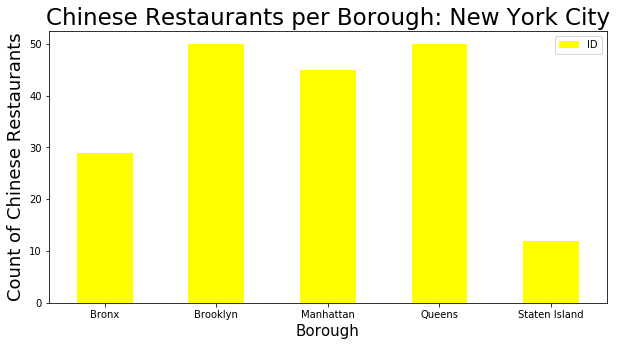

In [54]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as clr

chin_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='yellow')
plt.title('Chinese Restaurants per Borough: New York City', fontsize = 23)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Count of Chinese Restaurants', fontsize=18)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

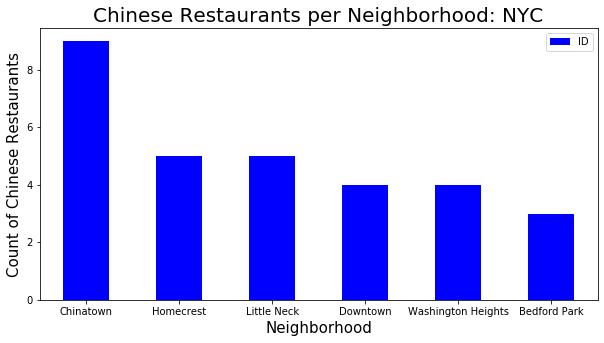

In [55]:
Neighbour = 6 # top number for graphing all the same past 6
chin_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(Neighbour).plot.bar(figsize=(10,5), color='blue')
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Count of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [99]:
list=['Chinatown','Homecrest','Little Neck','Downtown','Washington Heights']

china_rest=chin_rest_ny[chin_rest_ny['Neighborhood'].isin(list)]
china_rest

,Borough,Neighborhood,ID,Name
47,Brooklyn,Downtown,59da9590e1f0aa52976b8f35,Han Dynasty
48,Brooklyn,Downtown,5db3649a8d15ba00089b4e9b,Xi'an Famous Foods
49,Brooklyn,Downtown,585d72449f25836f2b2b7a1b,Xifu Food
50,Brooklyn,Downtown,5b7f3e462aff31002ce1bdc4,100% Mr Lin
58,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
59,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
60,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
61,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
62,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
63,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp


In [103]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
china_stat=pd.DataFrame(columns=column_names)
count=1
for row in china_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(china_rest),')','processed')
    china_stat = china_stat.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
china_stat.tail()

{'meta': {'code': 200, 'requestId': '611680a7020fd84016e54689'}, 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}], 'response': {'venue': {'id': '59da9590e1f0aa52976b8f35', 'name': 'Han Dynasty', 'contact': {}, 'location': {'address': '445 Albee Sq', 'crossStreet': 'Fleet St', 'lat': 40.691333919005594, 'lng': -73.98245632424464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691333919005594, 'lng': -73.98245632424464}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq (Fleet St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/59da9590e1f0aa52976b8f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1429

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
22,Brooklyn,Homecrest,4b46743ff964a520892126e3,"Golden ""Z"" Restaurant",3,7.6,6
23,Brooklyn,Homecrest,4d28b924ebacb1f72efbf34f,Wing Hing Seafood Restaurant,25,7.2,15
24,Brooklyn,Homecrest,514645bae4b0238f38bcdbac,Season Restaurant,9,5.7,3
25,Brooklyn,Homecrest,0,0,0,0.0,0
26,Brooklyn,Homecrest,0,0,0,0.0,0


In [118]:
china_rest_stat=china_stat[china_stat['Rating']>0]
china_rest_stat

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Downtown,59da9590e1f0aa52976b8f35,Han Dynasty,61.0,8.7,32.0
1,Brooklyn,Downtown,5db3649a8d15ba00089b4e9b,Xi'an Famous Foods,14.0,8.9,4.0
2,Brooklyn,Downtown,585d72449f25836f2b2b7a1b,Xifu Food,29.0,8.3,14.0
3,Brooklyn,Downtown,5b7f3e462aff31002ce1bdc4,100% Mr Lin,5.0,5.9,0.0
4,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village,510.0,8.8,180.0
5,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店,71.0,8.5,99.0
6,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods,107.0,9.1,29.0
7,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan,79.0,8.3,20.0
8,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown,217.0,8.0,285.0
9,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp,32.0,8.8,7.0


In [119]:
china_rest_stat.to_csv('china_rest_stat.csv') # As I move through this project I continue to save data to a .csv file

In [120]:
china_rest_stat.shape

(23, 7)

In [121]:
china_rest_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 24
Data columns (total 7 columns):
Borough         23 non-null object
Neighborhood    23 non-null object
ID              23 non-null object
Name            23 non-null object
Likes           23 non-null float64
Rating          23 non-null float64
Tips            23 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.4+ KB


In [123]:
china_rest_stat['Likes'] = china_rest_stat['Likes'].astype('float64')
china_rest_stat['Tips'] = china_rest_stat['Tips'].astype('float64')
china_rest_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 24
Data columns (total 7 columns):
Borough         23 non-null object
Neighborhood    23 non-null object
ID              23 non-null object
Name            23 non-null object
Likes           23 non-null float64
Rating          23 non-null float64
Tips            23 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.4+ KB


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [124]:
china_rest_stat.groupby('Borough').describe()

Likes                                                        Rating  \
          count       mean         std   min   25%   50%    75%    max  count   
Borough                                                                         
Brooklyn    7.0  20.857143   20.219039   3.0   7.0  14.0   27.0   61.0    7.0   
Manhattan  13.0  99.153846  141.977021   3.0   8.0  49.0  107.0  510.0   13.0   
Queens      3.0  52.000000   46.518813  10.0  27.0  44.0   73.0  102.0    3.0   

                                                         Tips             \
               mean       std  min   25%  50%  75%  max count       mean   
Borough                                                                    
Brooklyn   7.471429  1.286746  5.7  6.55  7.6  8.5  8.9   7.0  10.571429   
Manhattan  7.976923  0.913011  6.0  7.60  8.2  8.5  9.1  13.0  62.153846   
Queens     7.266667  0.723418  6.8  6.85  6.9  7.5  8.1   3.0  17.666667   

                                                    
                 std  min   25%   50%   75%    max  
Borough                                             
Brooklyn   10.982670  0.0   3.5   6.0  14.5   32.0  
Manhattan  88.433446  2.0   7.0  20.0  99.0  285.0  
Queens     13.576941  5.0  10.5  16.0  24.0   32.0

In [150]:
china_rest_stat_n=china_rest_stat.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
china_rest_stat_n.columns=['Neighborhood','Average Rating']
china_rest_stat_n.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Downtown,8.633333
0,Chinatown,8.488889
2,Little Neck,8.100000


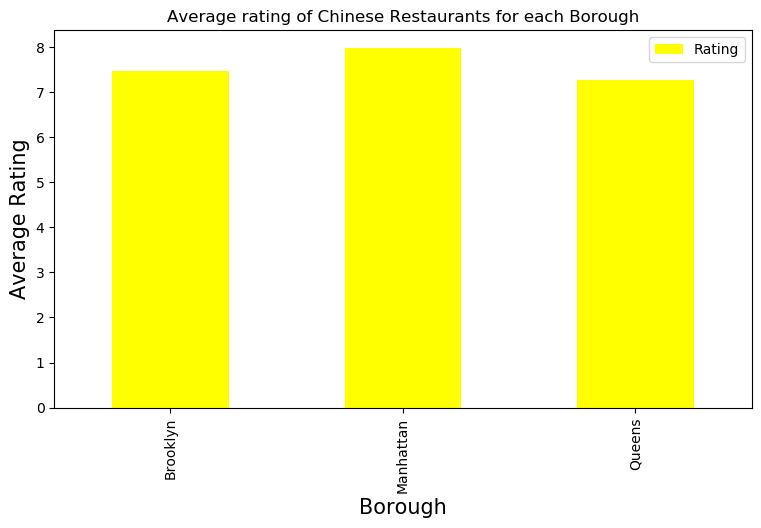

In [143]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
china_rest_stat.groupby('Borough').mean()['Rating'].plot(kind='bar', color='yellow')
plt.legend()
plt.show()

In [151]:
china_rest_stat_n=china_rest_stat_n[china_rest_stat_n['Average Rating']>=7.0]
china_rest_stat_n

,Neighborhood,Average Rating
0,Chinatown,8.488889
1,Downtown,8.633333
2,Little Neck,8.100000


In [152]:
ny_neighborhood_stats=pd.merge(china_rest_stat_n,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,8.488889
1,Brooklyn,Downtown,40.690844,-73.983463,8.633333
2,Queens,Little Neck,40.770826,-73.738898,8.100000


In [167]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [196]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map


for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    label = '{}'.format(label) # Define label here to reuse after
    folium.Marker(
        [lat, lng], 
        popup='Chinese Restaurants'
    ).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

Conclusion

Therefore, after data analysis and shown in map, there are 2 neighbourhoods which are close and with high ratings by people, which are Chinatown and Downtown. They have ratings higher than 8 and high amount of likes. As they are also near to each other, opening a CHinese restaurant there will have quite a amount of customers and will be beneficial for the business. As it means quite number people thre love to eat CHinese cuisine